## This Notebook - Goals - FOR EDINA 

**Aim:** <br>
The purpose of this Notebook is to introduce the user to some of the less well known methods of <code>matplotlib</code>, a standard python library pre-installed in the Noteable Standard and Geospatial Notebooks. It illustates the main features and advantages of this library when visualizing geospatial elevation data. The other aim of this Notebook is to demonstrate how the geospatial library of <code>rasterio</code> can be utilized to both process and plot geospatial data.  

**Target audience:** <br>
This Notebook is primarily aimed at users interested in geospatial data analysis. Academics and students in geosciences and other STEM degrees could benefit from the use of <code>rasterio</code> and <code>matplotlib</code>, either to practise geospatial data visualization skills or to specifically plot elevation maps using a standard library.
 
**Motivation:** <br>
The motivation behind creating this exemplar is to promote Noteable by showing the large variety of methods <code>matplotlib</code> and <code>rasterio</code> have that are pre-installed in the Geospatial Notebook.

**Noteable features to exploit:** <br>
This Notebook focuses on <code>matplotlib</code>, a standard data visualization library, and <code>rasterio</code>, a library that reads and visualizes geospatial raster data, included within the Geospatial Notebook. It utilizes <code>rasterio</code> and <code>gdal</code> to preprocess the open source data obtained from DigiMap, EDINA's service delivering digital map data and high quality cartographic products.

**How are the features exploited:** <br>
This Notebook uses <code>matplotlib</code> and <code>rasterio</code> as the main data visualization library and provides examples of its usage that can be used as templates by the viewer. It also uses geospatial data analysis libraries to process and convert the data into a format which can be plotted easily.

<hr>

# Plotting elevation data using Matplotlib and Rasterio
<code>Matplotlib</code> is a a python library for creating static, animated, and interactive visualizations. It can visualize both statistical and geospatial data, as long as the geoinformation has been preprocessed by other geospatial libraries. <br>
<code>Rasterio</code> is a reads and writes GeoTIFF and other formats to organize and store gridded, or raster, datasets which is mainly used by GIS.<br>
This Notebook uses OS terrain 50 DTM data of the Lake District, which was obtained from [Digimap](https://digimap.edina.ac.uk/os). This Notebook illustrates different ways of plotting the Lake District data using the <code>matplotlib</code> and <code>rasterio</code> librares. The main matplotlib methods used are <code>contour()</code> and <code>contourf()</code> along with the <code>rasterio.plot</code> module. 
An example of how <code>skimage</code> can be used to plot contour lines is also included.

**Notebook contents:**
- Importing the necessary libraries
- Pre-processing the OS terrain 50 DTM data of the Lake District
- Creating custom colourmaps to reflect typical terrain colours
- Terrain and contourmaps of the Lake District using <code>contour()</code> and <code>contourf()</code>
- Terrain and contourmaps of the Lake District using <code>imshow</code> and <code>skimage</code>
- Terrain and contourmaps of the Lake District using <code>rasterio</code>
- Terrain map of the Lake District overlayed on top of a hillshade 
- Customizing the colourbars of the maps

In [1]:
# Import all the necessary libraries
## General python libraries for data analysis and visualization
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Import libraries to preprocess the data
import zipfile, os
from osgeo import gdal, osr

import rasterio as rio

## Import geospatial libraries
import cartopy.crs as ccrs
from rasterio.plot import show
from skimage import measure

## Hide warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up function to customize the chosen matplotlib colormap
def truncate_colormap(cmap, minval, maxval, n=100):
    cmapsample = cmap(np.linspace(minval, maxval, n)) #Sample the original colormap at n points between minval and maxval
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
           'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmapsample)  #Create new colormap using the range that was sampled in cmapsample
    return new_cmap #Return new colormap that can be called upon with get_cmap

# See: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

In [3]:
# Create the colormap for the contourplots
from matplotlib.colors import LinearSegmentedColormap
cMap = []

custom = LinearSegmentedColormap.from_list(["darkgreen", "green", "mediumseagreen", 
                          "lightgreen", "greenyellow", "gold", "goldenrod", "darkgoldenrod", "brown", "black"], 
                                           ["darkgreen", "green", "mediumseagreen", 
                          "lightgreen", "greenyellow", "gold", "goldenrod", "darkgoldenrod", "brown", "black"], N=10)
m = matplotlib.cm.ScalarMappable(cmap=custom)

## Pre-processing the OS terrain 50 DTM data of the Lake District 
The data from Digimap can be downloaded in a zip file containing all the necessary files and documentation. The data contains Ordnance Survey data © Crown copyright and database right 2020. [[1]](#References) <br> 
Before it can be plotted, it first needs to be loaded into the Notebook and preprocessed. The unzipped folder reveals that the separate ascii files are split into folders named after the National Grid tiles they belong to. The files ending with ".asc" also need to be converted to ".tif" images and merged into one large ".tif" image to make plotting it easier.<br>
*Note: Tiff files can be plotted with <code>matplotlib</code> straight away, so any users who are hoping to visualize a geotiff file and are using this Notebook as a template can skip this section.*

In [4]:
# ONLY RUN ONCE

## Extract the folders from the zip file into a directory "./data/LakeDistrict"
z = zipfile.ZipFile('./LakeDistrictData/Lake_District.zip')
z.extractall(path="./data/LakeDistrict")

In [5]:
# ONLY RUN ONCE

## Convert each ".asc" file into a geotiff files
drv = gdal.GetDriverByName('GTiff')
for item in os.listdir("./data/LakeDistrict/terrain-50-dtm_3563996"):
    for i in os.listdir("./data/LakeDistrict/terrain-50-dtm_3563996/" + item):
        if i.endswith(".asc"):
            ds_in = gdal.Open('./data/LakeDistrict/terrain-50-dtm_3563996/' + item + "/" + i )
            i = i.strip('.asc')
            ds_out = drv.CreateCopy(i +'.tif', ds_in)
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(7405)
            ds_out.SetProjection(srs.ExportToWkt())
            ds_in = None
            ds_out = None

In [6]:
# ONLY RUN ONCE

## Combine all the individual geotiff files into one called "merged.tif"
!gdal_merge.py  -o merged.tif NY10.tif NY11.tif NY12.tif NY20.tif NY21.tif NY22.tif NY30.tif NY31.tif NY32.tif NY40.tif NY41.tif NY42.tif NY50.tif NY51.tif NY52.tif SD18.tif SD19.tif SD28.tif SD29.tif SD38.tif SD39.tif SD48.tif SD49.tif SD58.tif SD59.tif

proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_f

..proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
50proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
..proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
.60proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
proj_create_from_database: Cannot find proj.db
.proj_create_from_database: Cannot find proj.db
pro

In [7]:
# Load in the data using rasterio
src = rio.open("merged.tif")
elevation = src.read(1)

## Plotting elevation data using Matplotlib
This section illustrates different ways of plotting the Lake District data using the  <code>matplotlib</code> library. The first example uses the methods <code>contour()</code> and <code>contourf()</code>, whereas the second uses <code>plt.imshow</code> and the library called <code>skimage</code>. The data was loaded in using the library <code>rasterio</code> in both cases.

In [8]:
# Define a function to customize the plots with axis labels and titles to avoid repeating the same lines of code
def LDplot(title, axes, end):
    for i in range(0,end):
        axes[i].set_title(title[i], size=20)
        axes[i].set_xticks([310000, 320000, 330000, 340000, 350000, 360000])
        axes[i].set_xticklabels(["310km", "320km", "330km", "340km", "350km", "360km"])
        axes[i].set_yticks([480000, 490000, 500000, 510000, 520000, 530000])
        axes[i].set_yticklabels(["480km", "490km", "500km", "510km", "520km", "530km"])
        axes[i].set_xlabel("False Eastings")
        axes[i].set_ylabel("False Northings")

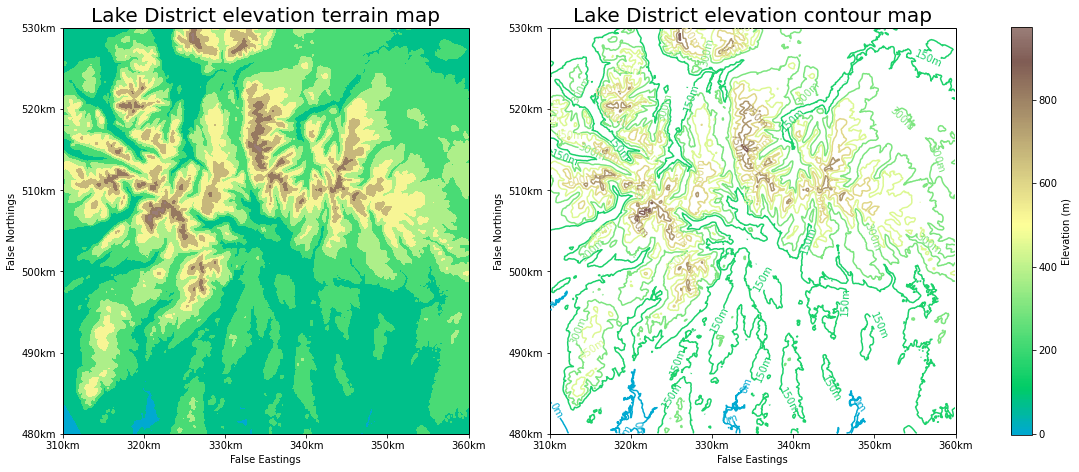

In [9]:
# Set figure size and axes
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.OSGB())
ax2= fig.add_subplot(1, 2, 2, projection=ccrs.OSGB())

# Create meshgrid with numpy
x = np.arange(310000, 360000, 50)
y = np.arange(480050, 530050, 50)
y = np.flip(y)
xx, yy = np.meshgrid(x, y, sparse=True)
'''Note: 
    I used meshgrid to be able to add axes ticklabels
    Can also use instead of meshgrid, but LDplot(title, axes, 2) has to be commented out first:
    ax.contour(src.read(1), cmap = customcmap, 
               title = "Lake District elevation contour map", 
               origin ="upper")'''

# Specify the colormap segment for this example - range from light blue to darkbrown
cmap = plt.get_cmap('terrain') # Colormap ranging darkblue-green-yellow-brown-white
new_cmap = truncate_colormap(cmap, 0.18, 0.8) # Cutting out darkblue and white ends

# Create terrain and contourmaps using contour and contourf
norm = matplotlib.colors.Normalize(vmin=np.nanmin(elevation),
                                   vmax=np.nanmax(elevation))

ax.contourf(x, y, src.read(1), cmap = new_cmap,
            title = "Lake District elevation contour map", norm=norm  )
CS = ax2.contour(x, y, src.read(1), cmap = new_cmap,
                 title = "Lake District elevation contour map", norm=norm )
ax2.clabel(CS, inline=1, fontsize=10, fmt='%1.fm')

# Add colorbar and customize the map
sm = plt.cm.ScalarMappable(norm = norm, cmap=new_cmap)
plt.colorbar(sm, ax=[ax, ax2], shrink = 0.75, label="Elevation (m)")

title =["Lake District elevation terrain map", "Lake District elevation contour map"]
axes = [ax, ax2]
LDplot(title, axes, 2)
plt.show()

# Save figure
#fig.savefig("LDmatplotlibcontour")

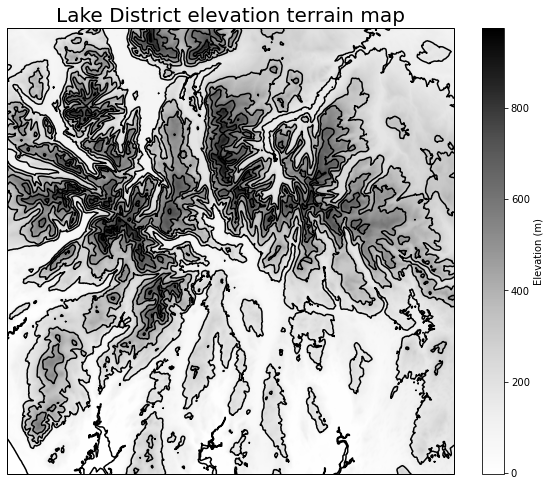

In [12]:
# Set figure size and axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.OSGB())

# Create terrainmap using imshow
plt.imshow(src.read(1), cmap="Greys", norm=norm)

# Add colorbar and customize the map
norm = matplotlib.colors.Normalize(vmin=np.nanmin(elevation), 
                                   vmax=np.nanmax(elevation))
sm = plt.cm.ScalarMappable(norm = norm, cmap="Greys")
plt.colorbar(sm, ax=ax, shrink=0.82, label="Elevation (m)")

ax.set_title("Lake District elevation terrain map", size=20)

# Create contours using skimage
interval = [0,150,300,450,600,750,900]
for height in interval:
    contours = measure.find_contours(src.read(1), height)
    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, c="black")

plt.show()

# Save figure
#fig.savefig("LDimshowblakandwhite")

## Plotting elevation data using Rasterio
This section illustrates plotting the Lake District data using <code>rasterio</code>. The first example uses the module <code>rasterio.plot</code>. Its  method <code>show</code> has an argument to plot contours or point data. The data was also loaded in using the library  <code>rasterio</code>.

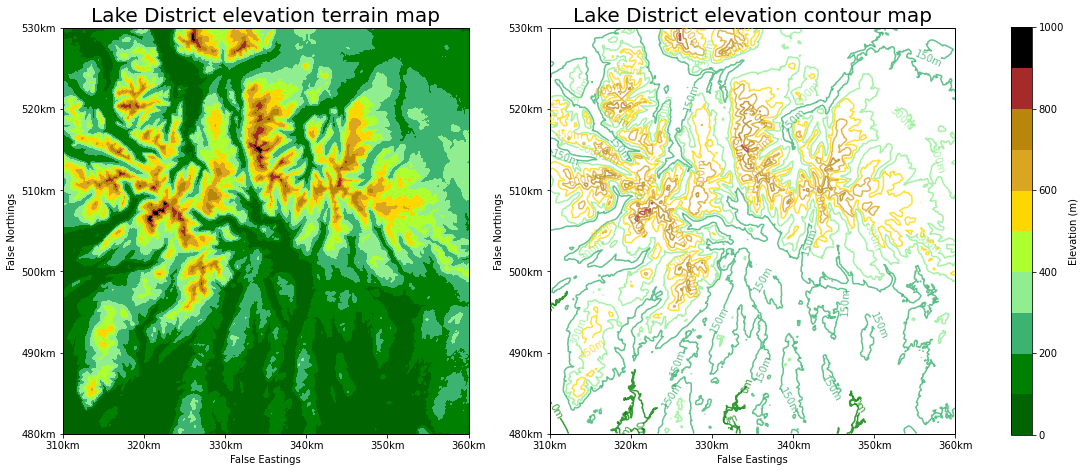

In [13]:
# Set figure size and axes
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.OSGB())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.OSGB())

# Specify the colormap segment for this example
customcmap = plt.get_cmap(custom) 

# Create terrain and contourmap using rasterio
show(src, ax=ax, cmap = customcmap, origin='upper',
     title = "Lake District elevation terrain map",
     transform = src.transform)
show(src, ax=ax2, cmap = customcmap,
     title = "Lake District elevation contour map",
     contour=True, 
     contour_label_kws = {'fmt':'%1.fm'},
     transform = src.transform)

# Add a colorbar and customize map
norm = matplotlib.colors.Normalize(vmin=0, vmax=1000)
sm = plt.cm.ScalarMappable(norm = norm, cmap=customcmap)
plt.colorbar(sm, ax=[ax, ax2], shrink = 0.75, label="Elevation (m)")

title =["Lake District elevation terrain map", "Lake District elevation contour map"]
axes = [ax, ax2]
LDplot(title, axes, 2)

plt.show()

# Save figure
#fig.savefig("LDrasterio") 

<a id='References'></a>
# References 

[1] OS Terrain 50 [ASC geospatial data], Scale 1:50000, Tiles: NY10, NY11, NY12, NY20, NY21, NY22, NY30, NY31, NY32, NY40, NY41, NY42, NY50, NY51, NY52, SD18, SD19, SD28, SD29, SD38, SD39, SD48, SD49, SD58, SD59, Updated: 29 May 2019, Ordnance Survey (GB), Using: EDINA Digimap Ordnance Survey Service, <https://digimap.edina.ac.uk>, Downloaded: 2020-06-11 09:06:43.042
